In [ ]:
import sys
import os
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from IPython.display import Image, display


In [2]:

GOOGLE_API_KEY=os.getenv("GEMINI_API_KEY1")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API")
HUGGINGFACE_API=os.getenv("HUGGINGFACE_API_KEY")
LANGCHAIN_PROJECT=os.getenv("LANGCHAIN_PROJECT") or "sample_agent_project"

In [3]:
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API

In [4]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
#embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [5]:
from langchain_groq import ChatGroq
import os
llm=ChatGroq(model_name="Gemma2-9b-It")

In [6]:

from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.messages import AIMessage

In [7]:

store={}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

In [8]:

model_with_memory=RunnableWithMessageHistory(llm,get_session_history)

In [9]:
config = {"configurable": {"session_id": "demo"}}

model_with_memory.invoke(("Hi! I'm from Nepal"),config=config).content


"Namaste! 👋 \n\nIt's lovely to hear from you.  \n\nIs there anything you'd like to talk about? Perhaps you have questions about me, or maybe you want to share something about Nepal? I'm here to listen and chat. 😊\n"

In [10]:
model_with_memory.invoke(("tell me where I am from?"),config=config).content


"You said you're from Nepal!  \n\nNepal is a beautiful country in South Asia, known for its stunning Himalayan mountains, including Mount Everest. 🏔️  \n\nHow are you enjoying your day today? 😊 \n"

In [11]:
store

{'demo': InMemoryChatMessageHistory(messages=[HumanMessage(content="Hi! I'm from Nepal", additional_kwargs={}, response_metadata={}), AIMessage(content="Namaste! 👋 \n\nIt's lovely to hear from you.  \n\nIs there anything you'd like to talk about? Perhaps you have questions about me, or maybe you want to share something about Nepal? I'm here to listen and chat. 😊\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 16, 'total_tokens': 73, 'completion_time': 0.103636364, 'prompt_time': 0.001964346, 'queue_time': 0.234450617, 'total_time': 0.10560071}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-4dad3829-6336-4b49-b424-92b0535142dd-0', usage_metadata={'input_tokens': 16, 'output_tokens': 57, 'total_tokens': 73}), HumanMessage(content='tell me where I am from?', additional_kwargs={}, response_metadata={}), AIMessage(content="You said you're from Nepal!  \n\nNepal i

## RAG

In [12]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain import PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough , RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [13]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

C:\Users\prabigya\AppData\Local\Temp\ipykernel_12104\3381050486.py:6: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
c:\Users\prabigya\miniconda3\envs\lang_graph_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\prabigya\miniconda3\envs\lang_graph_venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine 

In [17]:
loader = DirectoryLoader(r"C:\Users\prabigya\Desktop\work_here\langgraph_work\dataset_folder\txt_files", glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]


db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})


In [18]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = PromptTemplate.from_template(template)


retrieval_chain = (
    RunnableParallel({"context": retriever, "question": RunnablePassthrough()})
    | prompt
    | llm
    | StrOutputParser()
    )

In [20]:

question ="Fine Tuning vS RAG"
print(retrieval_chain.invoke(question))

When selecting between RAG and fine-tuning, consider the following:

* **RAG** is better for transparent solutions with dynamic data (e.g., customer-facing chatbots) because it enables adaptation to task-, user-, project- and organization-specific contexts without requiring multiple specialized models.

* **Fine-tuning** is better when deep domain customization is needed (e.g., healthcare). 


RAG systems are more complex than fine-tuning systems.  



## Tools and Agents

In [21]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

In [34]:
api_wrapper=WikipediaAPIWrapper()
tool1=WikipediaQueryRun(api_wrapper=api_wrapper)

In [35]:
print(tool1.run({"query": "langchain"}))

Page: LangChain
Summary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.



Page: Retrieval-augmented generation
Summary: Retrieval-augmented generation (RAG) is a technique that enables generative artificial intelligence (Gen AI) models to retrieve and incorporate new information. It modifies interactions with a large language model (LLM) so that the model responds to user queries with reference to a specified set of documents, using this information to supplement information from its pre-existing training data. This allows LLMs to use domain-specific and/or updated information.  Use cases include providing chatbot access to internal company data or generating responses based on authoritative sources.
RAG improves l

In [36]:
from langchain_community.tools import YouTubeSearchTool
tool2=YouTubeSearchTool()

In [37]:
tool2.invoke("sunne katha first video")

"['https://www.youtube.com/watch?v=UWofOk4UUx4&pp=ygUXc3VubmUga2F0aGEgZmlyc3QgdmlkZW8%3D', 'https://www.youtube.com/watch?v=UFx0m4AUz6U&pp=ygUXc3VubmUga2F0aGEgZmlyc3QgdmlkZW8%3D']"

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool3=TavilySearchResults()

In [39]:
tool3.invoke({"query": "What happened in the latest burning man floods"})


[{'title': 'Burning Man flooding: What happened to stranded festivalgoers?',
  'url': 'https://abcnews.go.com/US/burning-man-flooding-happened-stranded-festivalgoers/story?id=102908331',
  'content': 'Attendees look at a double rainbow over flooding on a desert plain at the Burning Man festival in Black Rock City, Nevada, September 1, 2023. Camps are set on a muddy desert plain at the Burning Man festival in Black Rock, City, Nevada, Sept. Structures stand in mud after heavy rain during the Burning Man festival in Black Rock City, Nevada, Sept. In response to the unusual weather, event organizers shut down traffic in or out of what is called Black Rock City -- where the festival is held in the desert -- including the local airport. Attendees look at a double rainbow over flooding on a desert plain at the Burning Man festival in Black Rock City, Nevada, September 1, 2023.',
  'score': 0.7395922},
 {'title': "How One Man Escaped From Burning Man 2023's Floods",
  'url': 'https://www.outs

In [41]:
from langchain.agents import AgentType
from langchain.agents import load_tools 
from langchain.agents import initialize_agent

In [42]:
tools =[tool1,tool2,tool3]
agent=initialize_agent(tools,llm,agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,verbose=True)


C:\Users\prabigya\AppData\Local\Temp\ipykernel_12104\3692051841.py:2: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent=initialize_agent(tools,llm,agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,verbose=True)


In [43]:
agent.run("What is current GDP of India?")

C:\Users\prabigya\AppData\Local\Temp\ipykernel_12104\1884584589.py:1: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  agent.run("What is current GDP of India?")




> Entering new AgentExecutor chain...
Thought: I need to find the current GDP of India. Tavily should be good for this as it is optimized for current information.
Action: tavily_search_results_json
Action Input: India GDP 
Observation: [{'title': 'India GDP - Trading Economics', 'url': 'https://tradingeconomics.com/india/gdp', 'content': 'India GDP Interest Rate India GDP The Gross Domestic Product (GDP) in India was worth 3549.92 billion US dollars in 2023, according to official data from the World Bank. This page provides the latest reported value for - India GDP - plus previous releases, historical high and low, short-term forecast and long-term prediction, economic calendar, survey consensus and news. | GDP Growth Rate YoY | 5.40 | 6.70 | percent | Sep 2024 | | GDP Growth Rate | 1.10 | 1.10 | percent | Sep 2024 | India GDP GDP GDP GDP Growth Rate GDP Growth Rate YoY Economic Calendar Historical Data News Stream Earnings Releases Credit Ratings Forecasts Markets Currencies Stocks 

'The current GDP of India is 3549.92 billion US dollars.'

In [47]:
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    input: str
    response: str

In [55]:
a=State(response="b")
a

{'response': 'b'}

In [50]:
def generate_response(state: State) -> State:
    response = llm.invoke(state["input"])
    return {"response": response.content}

def refine_response(state: State) -> State:
    prompt = f"Refine this response to be more concise: {state['response']}"
    refined = llm.invoke(prompt)
    return {"response": refined.content}

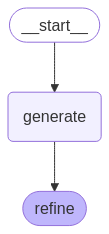

In [56]:
graph = StateGraph(State)
graph.add_node("generate", generate_response)
graph.add_node("refine", refine_response)

# Add edges
graph.add_edge("generate", "refine")
#graph.add_edge("refine", END)

# Set the entry point
graph.set_entry_point("generate")

# Compile the graph
chain = graph.compile()


try:
    display(Image(chain.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass